# PA005: High Value Customer Identification (Insiders)

## 0.0 Planejamento da solução (IoT)

### Entrada (input)

1. Problema de negócio:
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
2. Conjunto de dados:
    - Vendas de um e-commerce online, durante o período de 1 ano (11/2015 a 12/2017)
    

### Saída (output)

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
           10323     | yes/1 
           32413     | no/1
             
2. Relatório om as perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo ?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda dos Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento ?

### Tarefas (tasks)

- Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível ? O que são clientes de maior "valor" ?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV
        - Baixo recência
        - Alto basket size
        - Baixa probabilidade de churn
        - Alta previsão LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução
        
        
    - Experiência de Compra:
        - Média Alta de avaliações
        
        
- Quantos clientes farão parte do grupo ?
    - Número total de clientes
    - % clientes Insiders
    
- Quais as principais características desses clientes ?
    - Escrever características do cliente:
        - Idade
        - Localização
        
    - Escrever características de consumo:
        - Atributos da clusterização
        
        
- Qual a porcentagem de contribuição do faturamento, vinda dos Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
- Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort
    
- Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir periodicidade (1 mês, 3 meses ...)
    - A pessoa precisa ser similar ou parecida com outra pessoa do grupo
    
- Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir periodicidade (1 mês, 3 meses ...)
    - A pessoa precisa ser dessimilar ou não parecida com outra pessoa do grupo
    
- Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste de hipóteses
    - Teste A/B Bayesiano

- Quais ações o time de marketing pode realizar para aumentar o faturamento ?
     - Desconto
     - Preferencia de compra
     - Frete
     - Visita a empresa

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from umap.umap_ import UMAP

import re

# 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24,9]
    plt.rcParams['font.size'] = 15
    
#     display(HTML('<style>.container { width:100% important;}</style>'))
    pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 Load Data

In [3]:
caminho = r'C:\repos\portfolio_projetos\pa005_insider_clustering\data'
df_raw = pd.read_csv(caminho + '\Ecommerce.csv', encoding = 'iso 8859-1')
df_raw = df_raw.drop(['Unnamed: 8'], axis = 1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


# 1.0 Descrição os dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [5]:
cols_new = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']

df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.2 Data dimension

In [6]:
print("Number of rows: {} \nNumber of columns: {}".format(df1.shape[0], df1.shape[1]))

Number of rows: 541909 
Number of columns: 8


## 1.3 Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [9]:
# remove
df1 = df1.dropna(subset = ['description','customer_id'])

print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

Removed data: 24.93%


In [10]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change dtypes

In [11]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])


### 1.7.1 Numerical Attributes

In [14]:
# central tendency - mean / median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std / skew / kurtosis / min / max
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,12.06,5.00,248.69,0.18,94317.56
1,unit_price,0.00,38970.00,38970.00,3.46,1.95,69.32,452.22,246924.54
2,customer_id,12346.00,18287.00,5941.00,15287.69,15152.00,1713.60,0.03,-1.18


In [15]:
# quantidade com valor negativo ? (Devolução)
# preço unitario de zero ? Promoção ?


### 1.7.2 Categorical Attributes

In [16]:
# cat_attributes['invoice_no'].astype('int64')
# invoice_no
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool(re.search('[^0-9]+', x)) )]
print('Total of invoices with letter: ', df_letter_invoices.shape[0])
print('Total of invoices with letter and quantity < 0: ',df_letter_invoices.loc[
                                        df_letter_invoices['quantity'] < 0].shape[0])

Total of invoices with letter:  8905
Total of invoices with letter and quantity < 0:  8905


In [17]:
# stock code
# pegar somente letras
df1.loc[df1['stock_code'].apply( lambda x: bool(re.search('^[a-zA-Z]+$', x)) ),
                   'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [18]:
# acao:  remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


In [19]:
# description
df1.head()

# delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [20]:
# country
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [21]:
df1['country'].value_counts( normalize = True).head()

United Kingdom   0.89
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.01
Name: country, dtype: float64

In [22]:
df1[['country','customer_id']].drop_duplicates().groupby('country').count().sort_values(by = 'customer_id',
                                                                                        ascending = False).head()

,customer_id
country,
United Kingdom,3950
Germany,95
France,87
Spain,31
Belgium,25


# 2.0 Filtragem das variáveis

In [23]:
df2 = df1.copy()

In [24]:
df2.sort_values(['customer_id','invoice_no','description']).head(10) 
# há devolução se olhar o primeiro individuo, pois o "C" parece ser a flag para devolução

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2017-01-16,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,12346,United Kingdom
14966,537626,84558A,3D DOG PICTURE PLAYING CARDS,24,2016-12-05,2.95,12347,Iceland
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2016-12-05,4.25,12347,Iceland
14948,537626,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,2016-12-05,3.75,12347,Iceland
14949,537626,22726,ALARM CLOCK BAKELIKE GREEN,4,2016-12-05,3.75,12347,Iceland
14952,537626,22729,ALARM CLOCK BAKELIKE ORANGE,4,2016-12-05,3.75,12347,Iceland
14951,537626,22728,ALARM CLOCK BAKELIKE PINK,4,2016-12-05,3.75,12347,Iceland
14950,537626,22727,ALARM CLOCK BAKELIKE RED,4,2016-12-05,3.75,12347,Iceland
14955,537626,21171,BATHROOM METAL SIGN,12,2016-12-05,1.45,12347,Iceland


In [25]:
# quantity (negative)
df2.loc[df2['quantity'] < 0 ].sort_values('invoice_no').head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom


In [26]:
#====== NUMERICAL ===========
# unity price > 0
df2 = df2.loc[df2['unit_price'] > 0.040]

# stock code != ['POST, D, M, DOT, CRUK]
df2 = df2.loc[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'] ) ]

# description
df2 = df2.drop(['description'], axis = 1)

# country change
df2 = df2.loc[ ~df2['country'].isin( ['Unspecified','European Community'])]
# df2['country'] = df2['country'].apply( lambda x: 'Ireland' if x == 'EIRE' else
#                                      'United States' if x == 'USA' else
#                                      'South Africa' if x == 'RSA' else x)


# quantity
df2_returns = df2.loc[ df2['quantity'] < 0]
df2_purchases = df2.loc[ df2['quantity'] >= 0]

# 3.0 Feature Engineering

In [33]:
df3 = df2.copy()

## 2.1 Feature creation

In [34]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis = 1).drop_duplicates().reset_index(drop = True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [35]:
# gross revenue = quantity * price (faturamento)
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

In [36]:
# monetary
df_monetary = df2_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

In [37]:
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id',how = 'left')

df_ref.isna().sum() # tem NA por conta de ser somente as compras 'positivas'

customer_id       0
gross_revenue    27
dtype: int64

In [39]:
# recency - last day purchase
df_recency = df2_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()

# pego o df1 com max() pois eu considero que seria eu olhando pra "hoje" no meu dataset e tirando 'hoje - datas'
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [40]:
df_ref.head()

,customer_id,gross_revenue,recency_days
0,17850,5391.21,372.00
1,13047,3232.59,56.00
2,12583,6705.38,2.00
3,13748,948.25,95.00
4,15100,876.00,333.00


In [41]:
# frequency
df_frequency = df2_purchases[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_frequency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [42]:
# average ticket
df_avg_ticket = df2_purchases[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(
                                                            columns = {'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [43]:
# number of returns
df_returns = df2_returns[['customer_id','invoice_no']].drop_duplicates().groupby(
                        'customer_id').count().reset_index().rename(columns = {'invoice_no':'returns'})
df_ref = pd.merge(df_ref, df_returns, on = 'customer_id', how = 'left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [44]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.00,34.00,18.15,1.00
1,13047,3232.59,56.00,9.00,18.90,7.00
2,12583,6705.38,2.00,15.00,28.90,2.00
3,13748,948.25,95.00,5.00,33.87,0.00
4,15100,876.00,333.00,3.00,292.00,3.00


# 4.0 Análise Exploratória dos Dados

In [45]:
df4 = df_ref.dropna().copy()

In [46]:
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
returns          0
dtype: int64

# 5.0 Data Preparation

In [71]:
df5 = df4.copy()

In [72]:
# sns.distplot(df5['gross_revenue']);

In [73]:
ss = StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['returns'] = ss.fit_transform( df5[['returns']] )

# 6.0 Feature Selection

In [74]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine Tunning

In [75]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,0.38,2.79,3.89,-0.03,0.11
1,13047,0.14,-0.36,0.62,-0.03,3.16
2,12583,0.52,-0.90,1.41,-0.03,0.62
3,13748,-0.12,0.03,0.10,-0.02,-0.39
4,15100,-0.13,2.40,-0.16,0.15,1.13


In [76]:
X = df6.drop(['customer_id'], axis = 1)
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,0.38,2.79,3.89,-0.03,0.11
1,0.14,-0.36,0.62,-0.03,3.16
2,0.52,-0.90,1.41,-0.03,0.62
3,-0.12,0.03,0.10,-0.02,-0.39
4,-0.13,2.40,-0.16,0.15,1.13


In [77]:
clusters = [2,3,4,5,6,7]

## 7.1 Within-Cluster Sum of Squares (WSS)

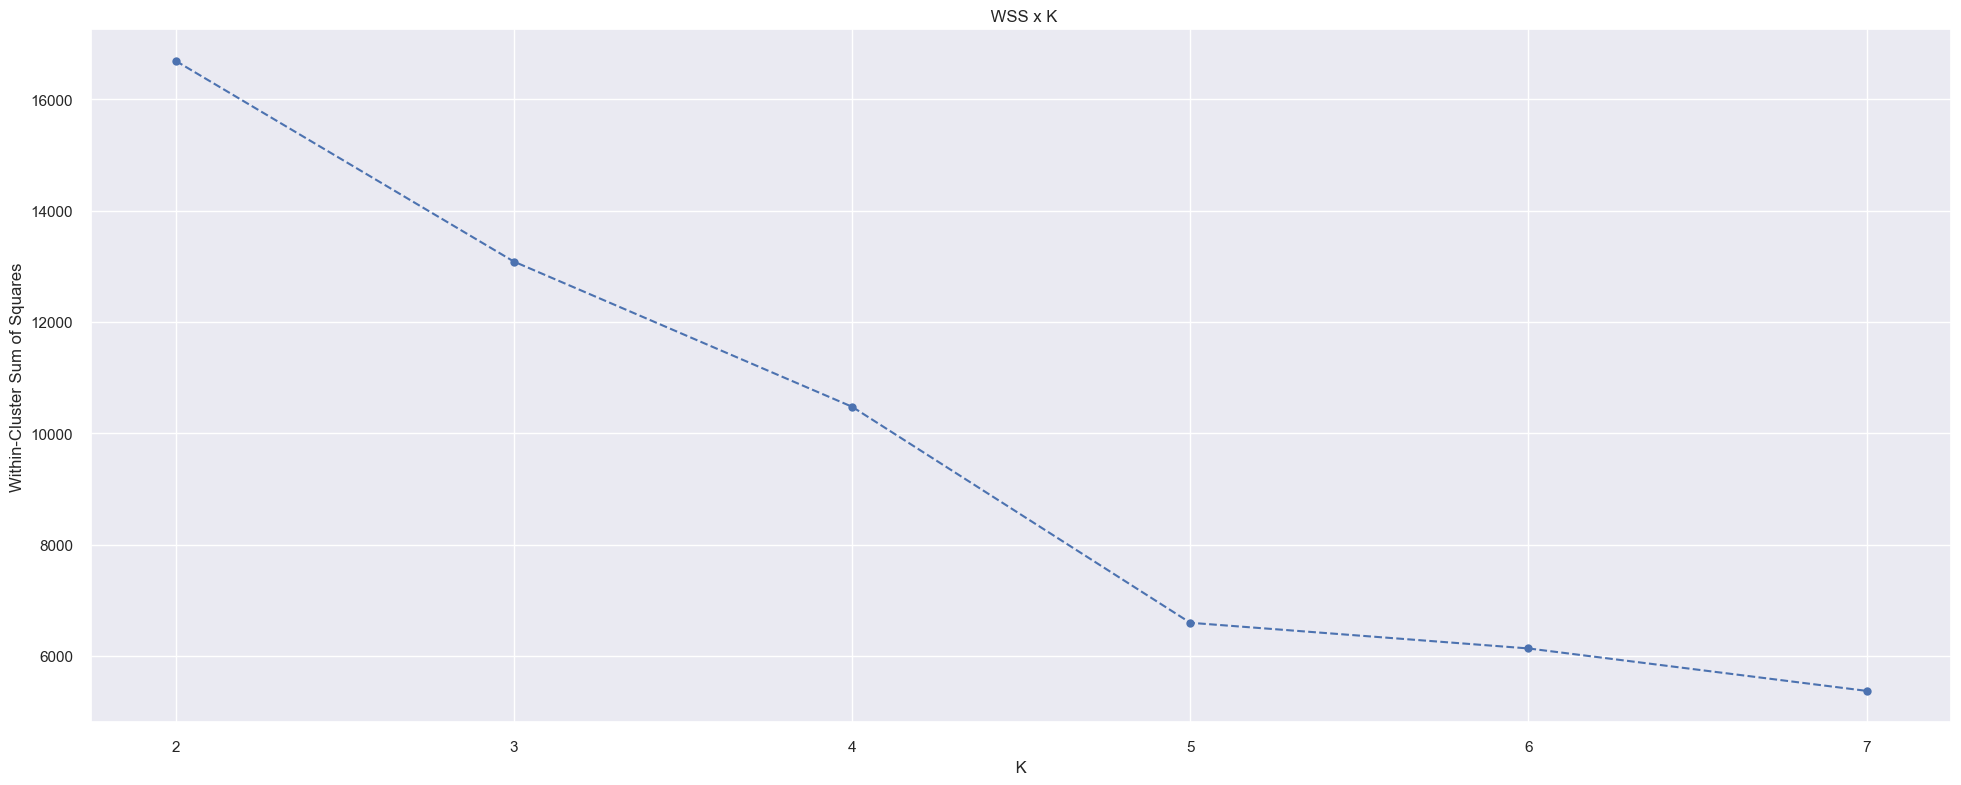

In [78]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init = 'random', n_clusters= k, n_init = 10, max_iter= 300, random_state= 42)

    # model training
    kmeans.fit(X)

    # validation
    wss.append(kmeans.inertia_)

# plot wss - elbow method
plt.plot( clusters, wss, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel(' K ')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title(' WSS x K');

## 7.2 Silhouette Score

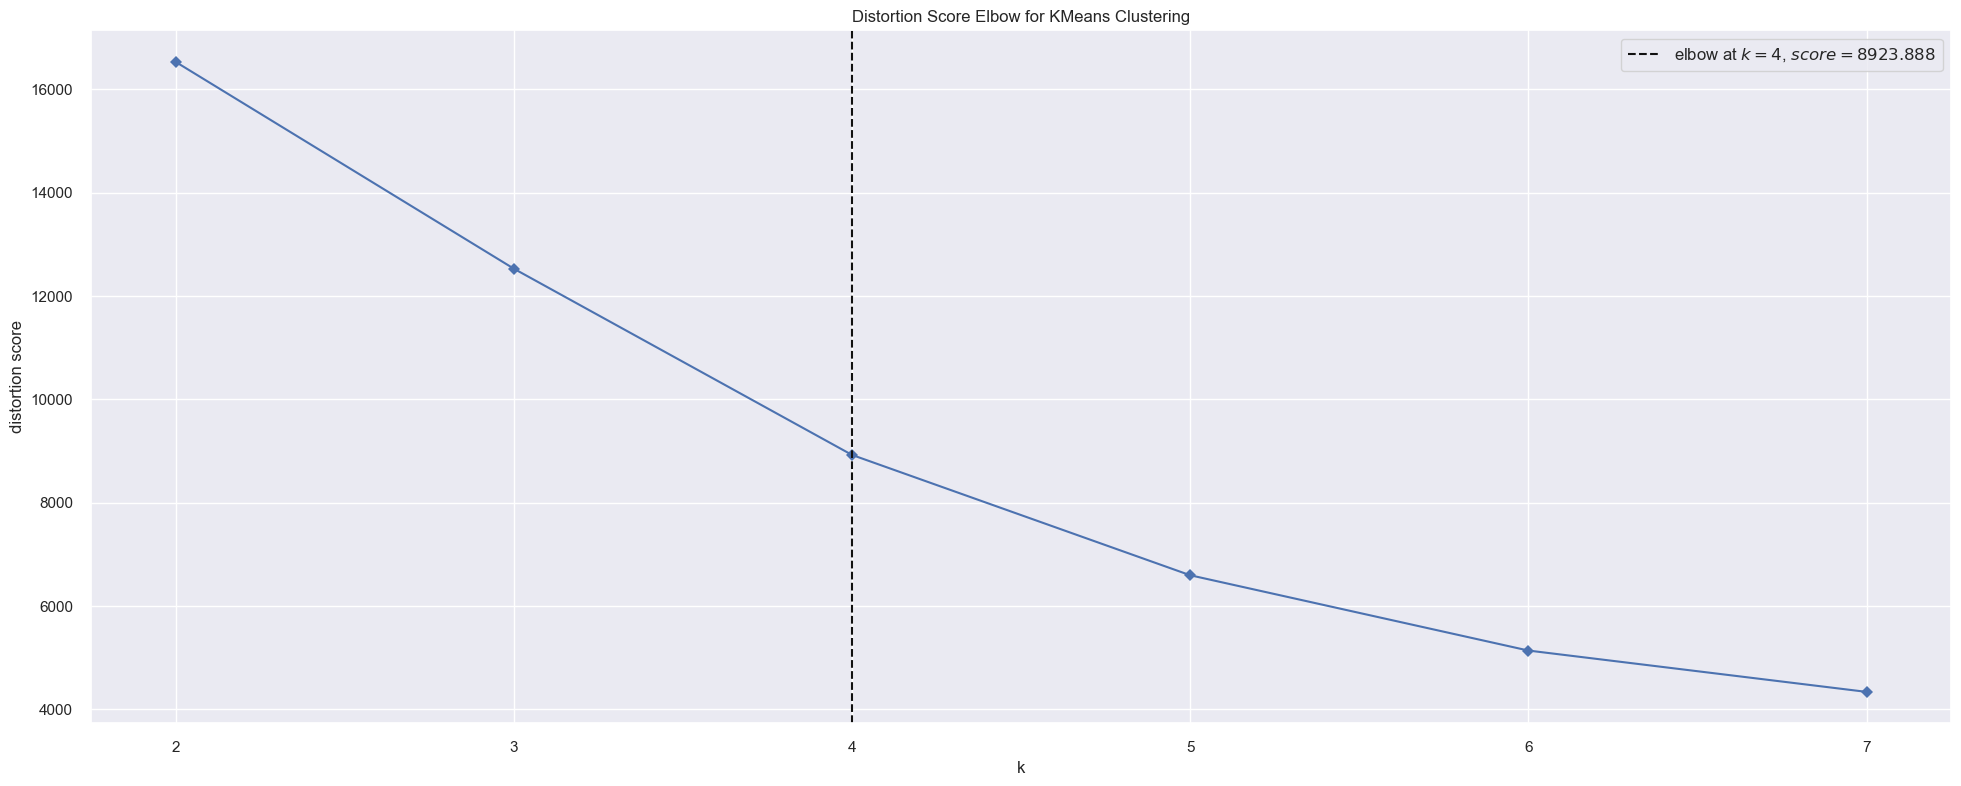

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [79]:
kmeans = KElbowVisualizer(KMeans(), k = clusters, timings=False)
kmeans.fit(X)
kmeans.show()

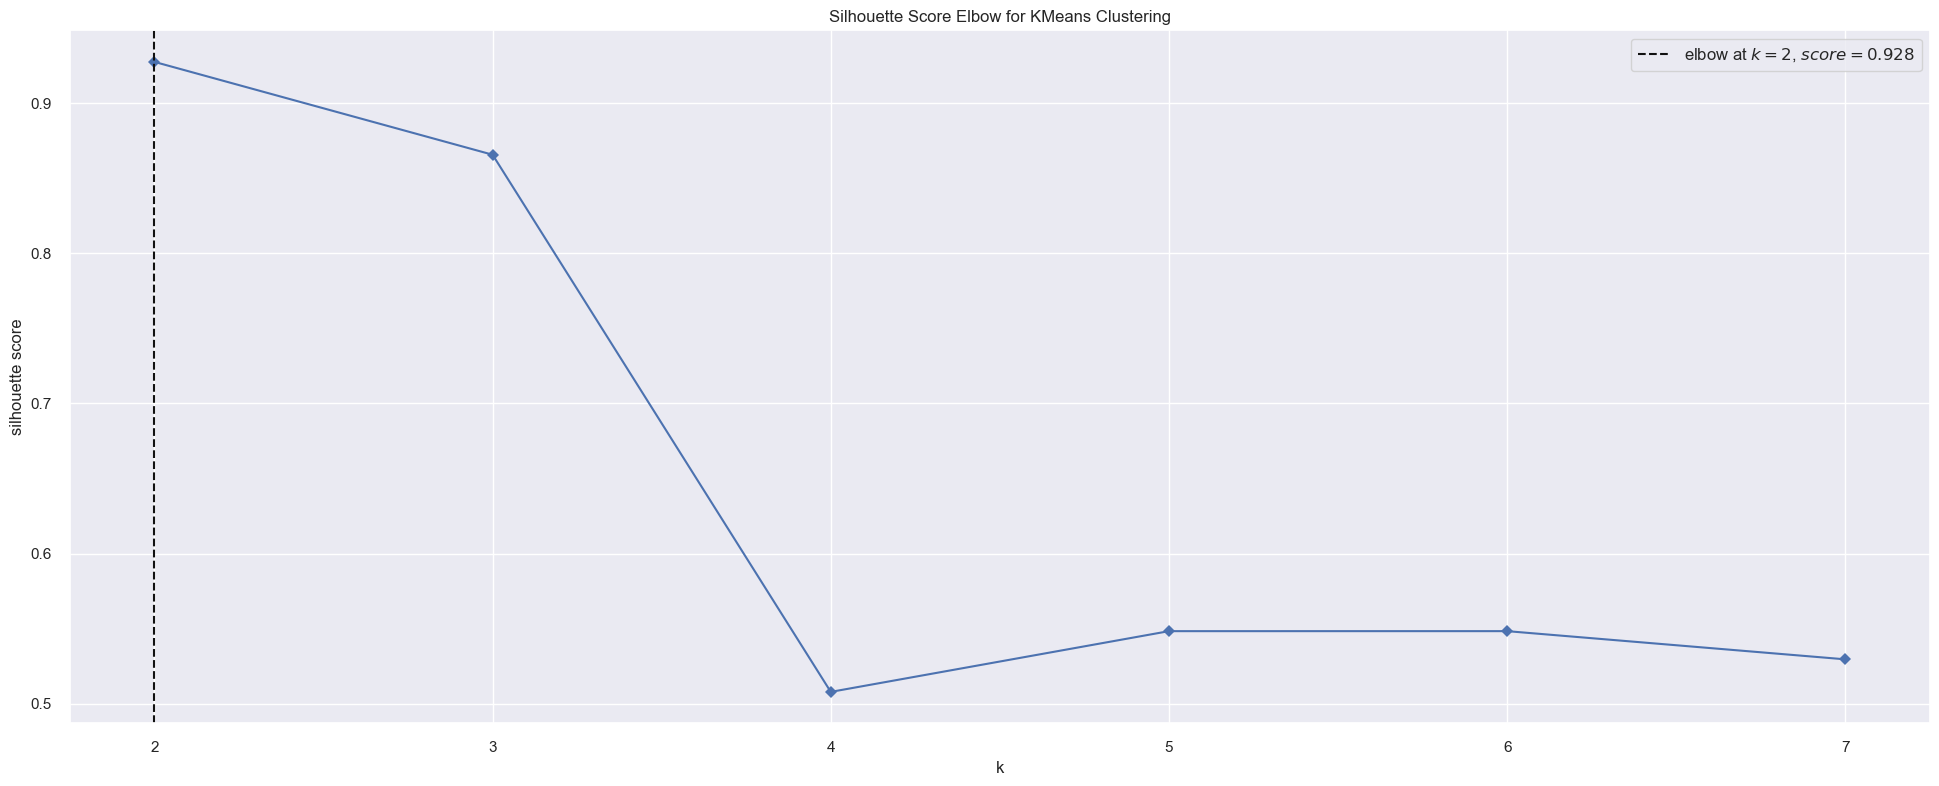

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [80]:
kmeans = KElbowVisualizer(KMeans(), k = clusters, metric= 'silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

## 7.3 Silhouette Analysis

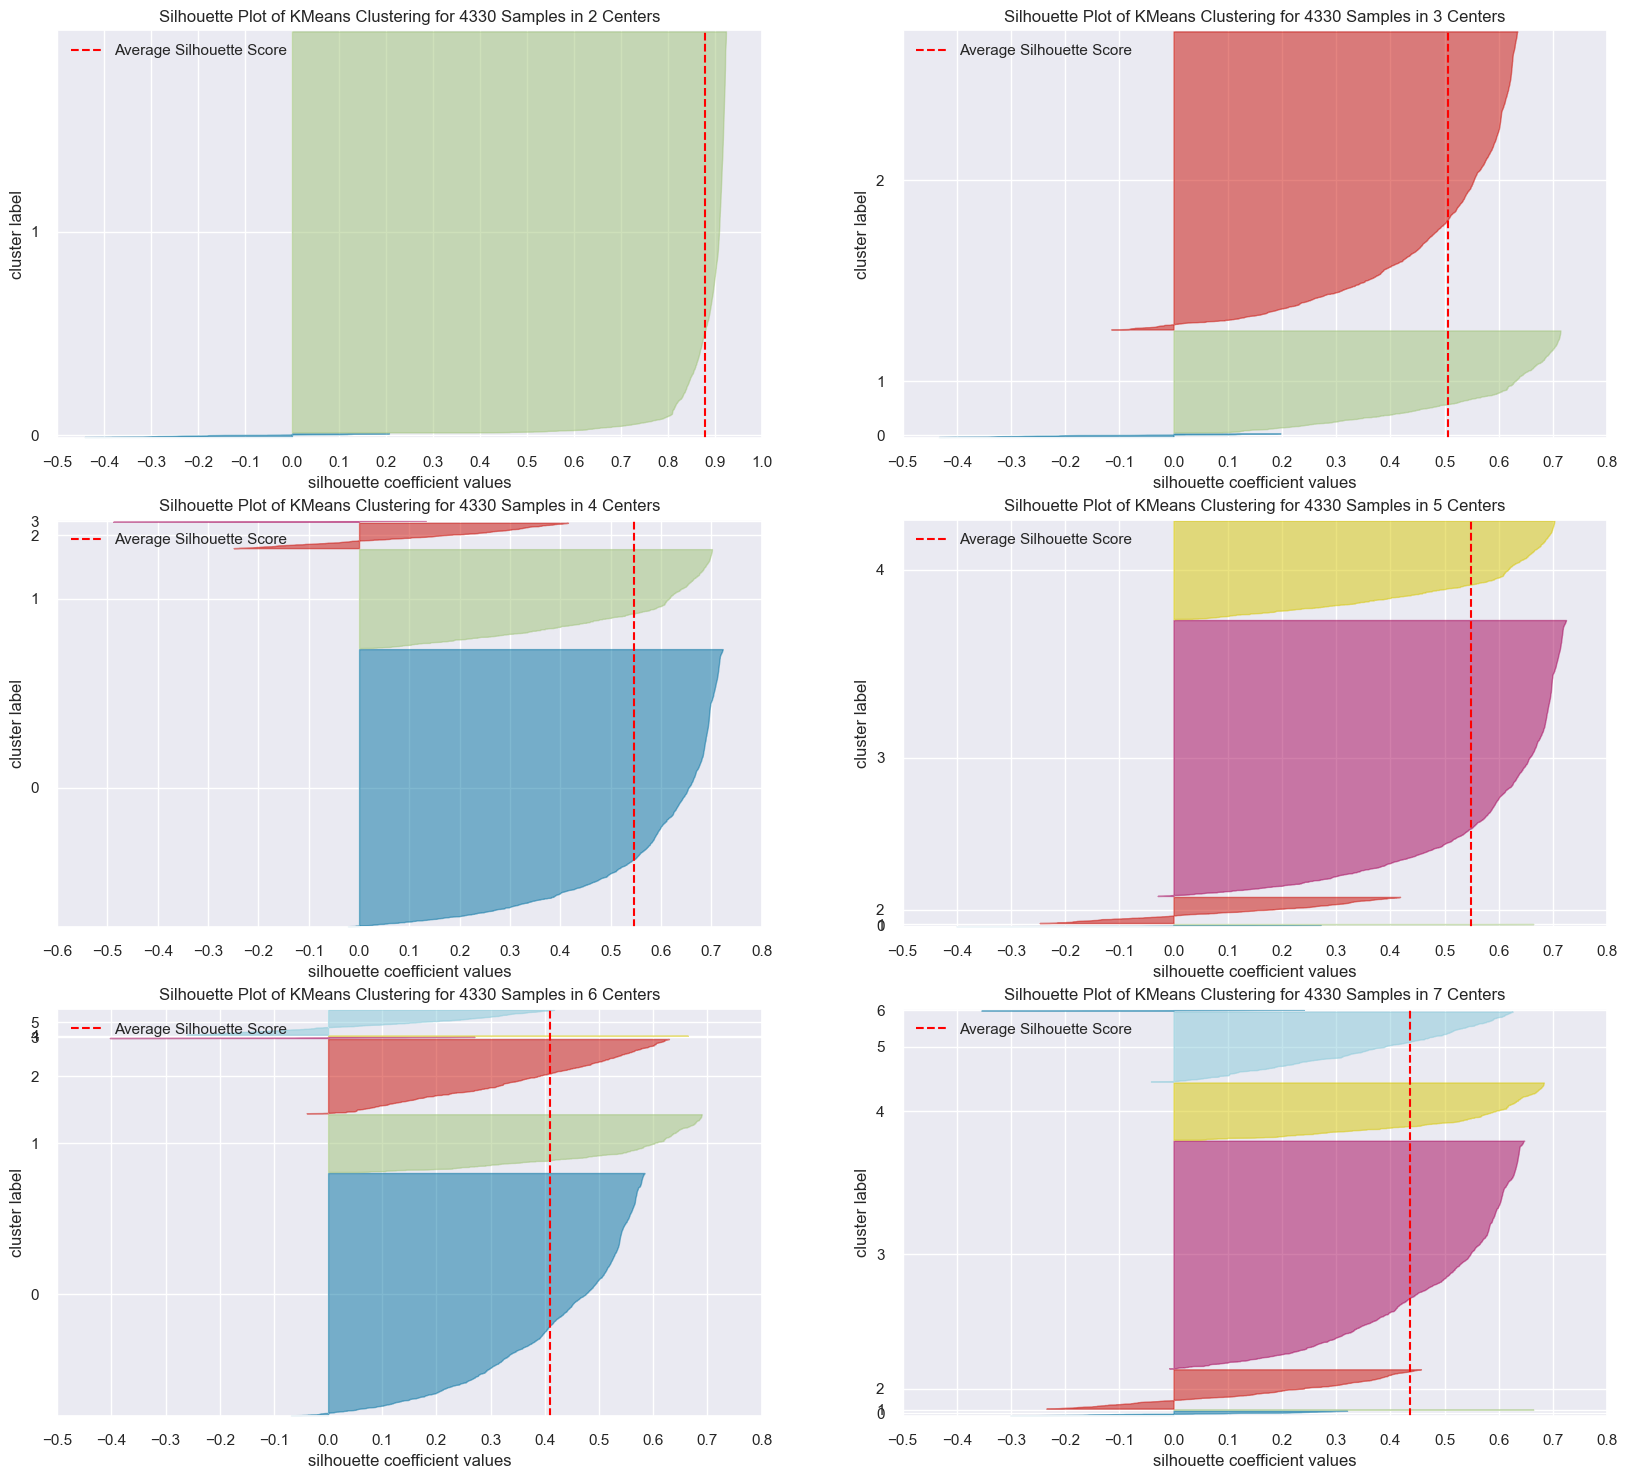

In [81]:
fig, axes = plt.subplots(3,2,figsize=(20,18))
for k in clusters:
    km = KMeans(n_clusters=k, init= 'random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod( k, 2)
    visualizer = SilhouetteVisualizer(km,colors = 'yellowbrick', ax = axes[q-1,mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [82]:
# model definition
k = 3
kmeans = KMeans(init= 'random', n_clusters= k, n_init= 10, max_iter= 300, random_state= 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [83]:
# WSS
print('WSS score: {}'.format(kmeans.inertia_))

## SS
print('SS score: {}'.format(silhouette_score(X, labels, metric = 'euclidean')))


WSS score: 13085.440009771166
SS score: 0.5060641637777309


# 9.0 Cluster Analysis

In [84]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1  Visualization Inspection

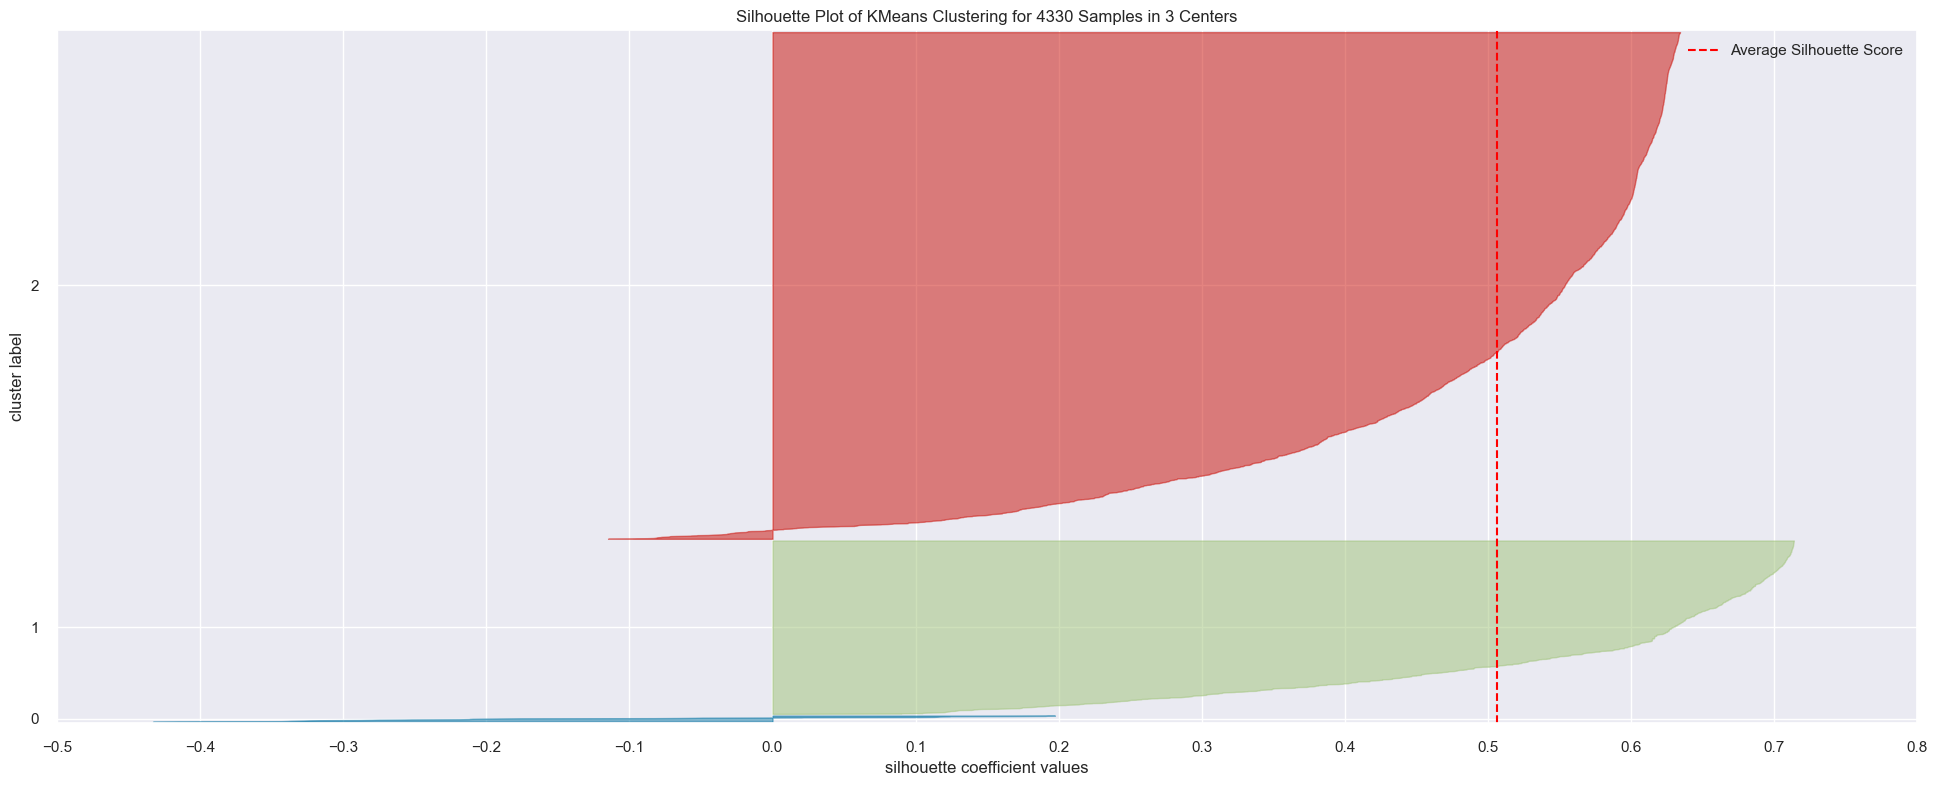

In [85]:
visualizer = SilhouetteVisualizer( kmeans, colors = 'yellowbrick')
visualizer.fit( X )
visualizer.finalize()

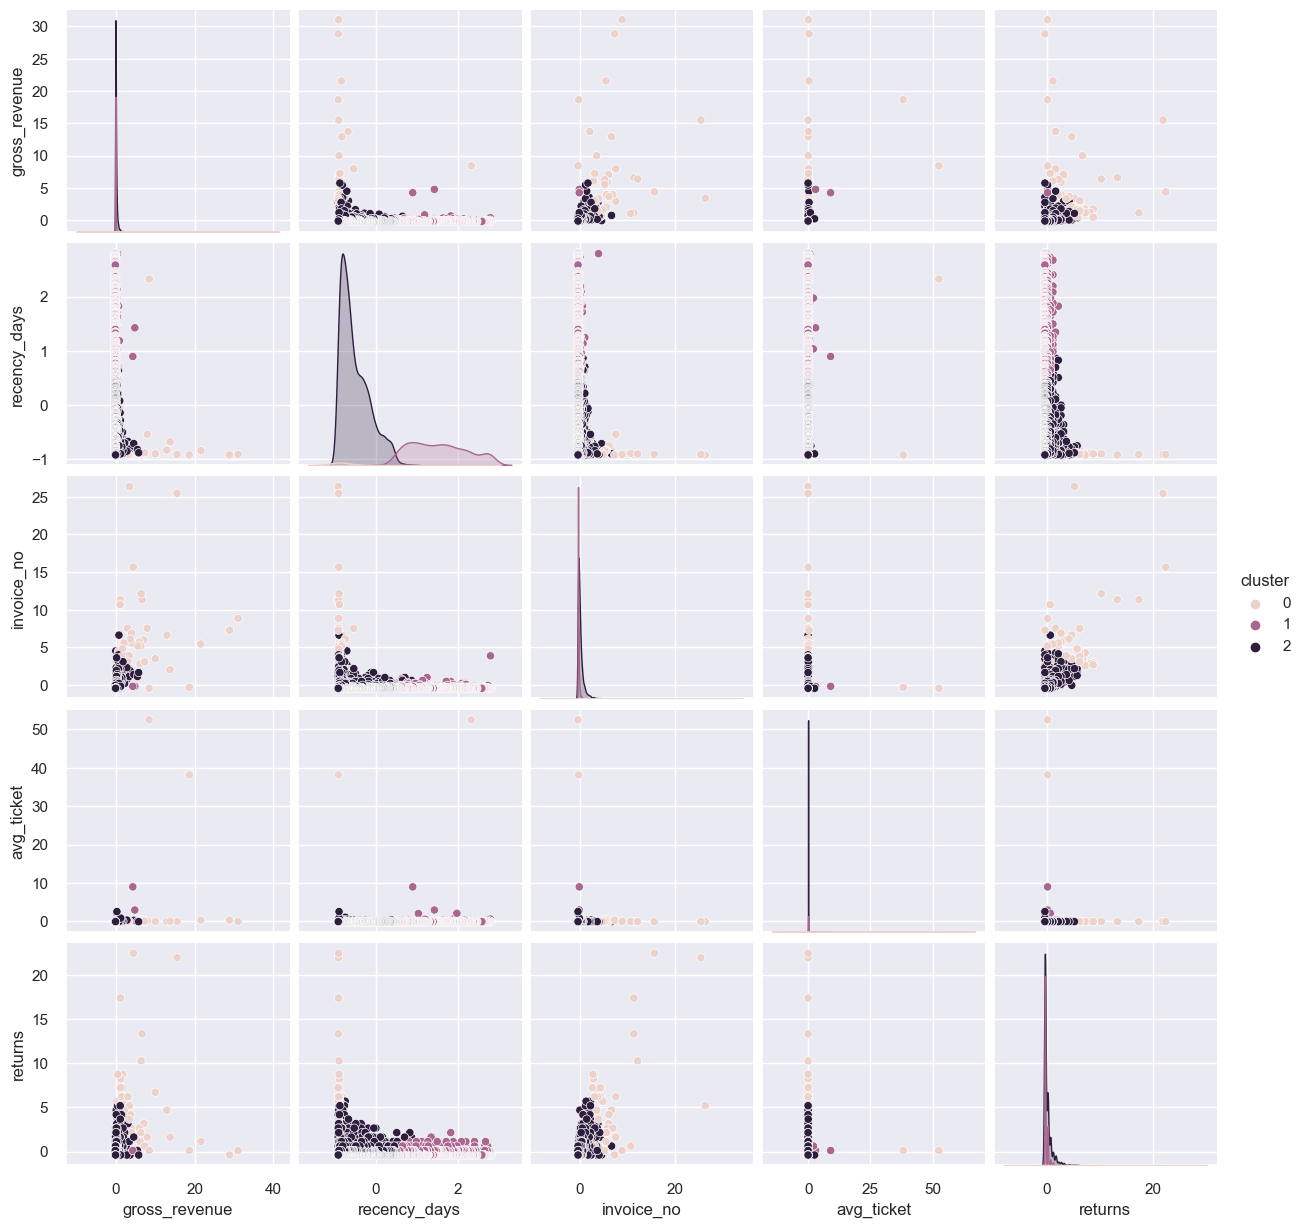

In [86]:
df_viz = df9.drop(['customer_id'], axis = 1)

sns.pairplot( df_viz, hue = 'cluster')

## 9.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

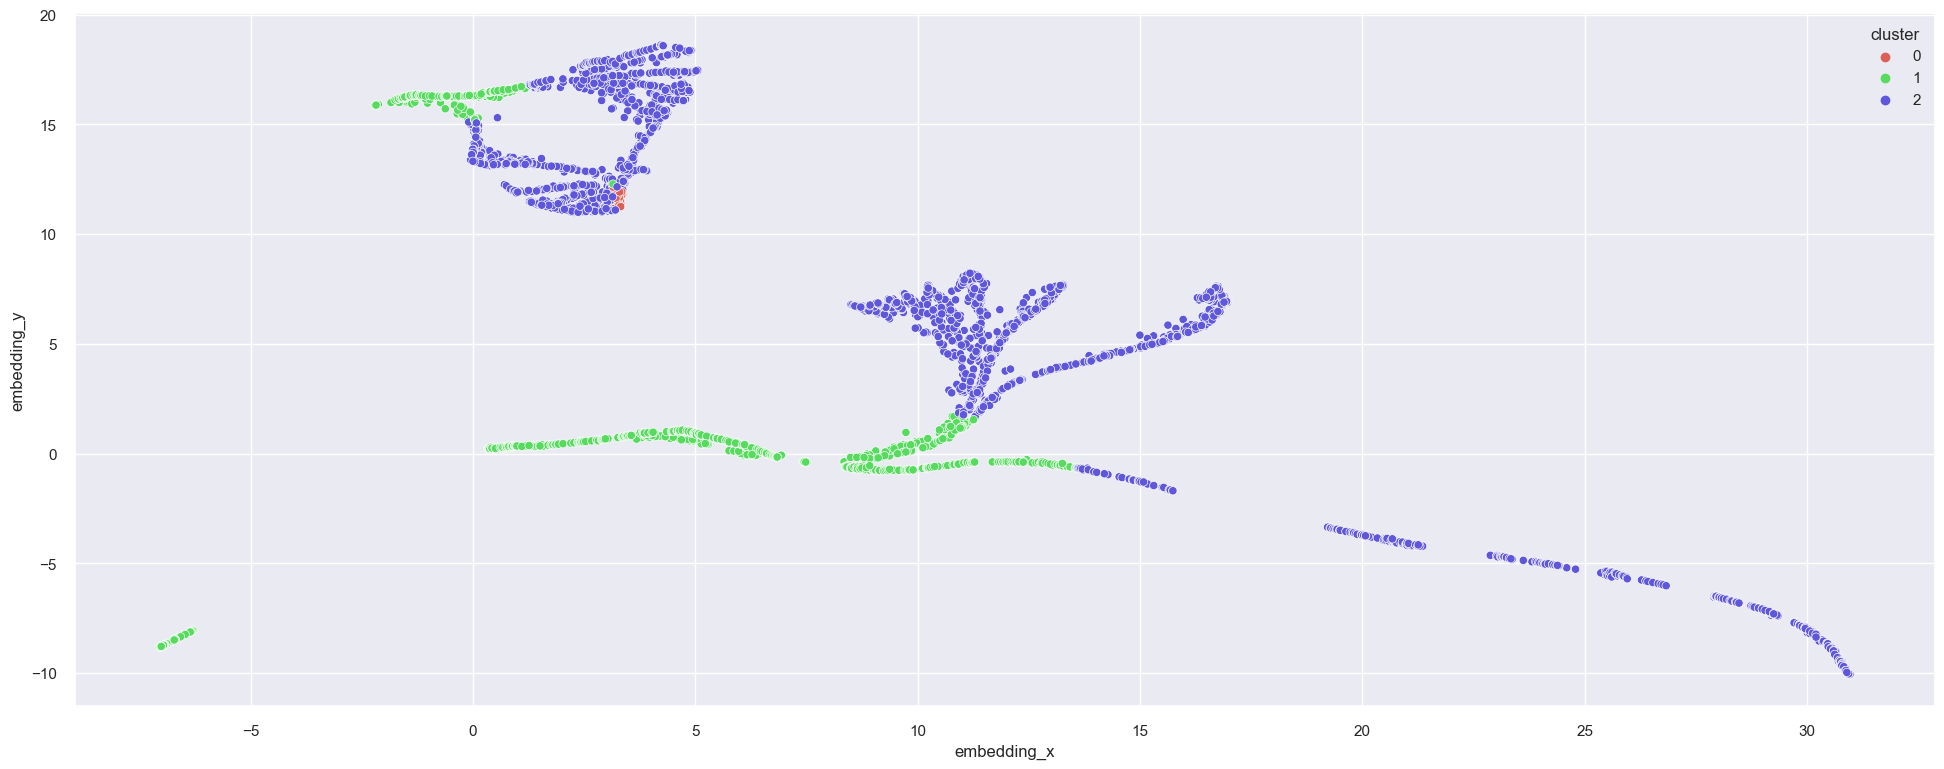

In [89]:
reducer = UMAP(n_neighbors = 100,random_state= 42) 
# possui um hyperparametro chamado 'n_neighbors', que quanto menor, mais proximo do minimo local convergirá....quanto maior, mais se aproxima do minimo global

embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y',
                hue = 'cluster',palette = sns.color_palette('hls',n_colors = len(df_viz['cluster'].unique() ) ),
                data= df_viz
                )

## 9.2 Cluster Profile

In [88]:
# number of customer
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# average gross revenue
df_cluster_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_gross_revenue, on = 'cluster', how = 'left')

# average recency days
df_cluster_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_recency_days, on = 'cluster', how = 'left')

# average invoice no
df_cluster_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_invoice_no, on = 'cluster', how = 'left')

# average ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, on = 'cluster', how = 'inner')


df_cluster

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,40,0.92,6.69,-0.79,6.50,2.31
1,1,1094,25.27,-0.17,1.53,-0.35,-0.01
2,2,3196,73.81,-0.03,-0.51,0.04,-0.03


- Cluster 01:
    - Número de clientes: 6 (0,14 % do total)
    - Recência média de 7 dias
    - Compras em média de 89 compras
    - Receita média de $ 182.181,98
    

- Cluster 02:
    - Número de clientes: 31 (0,71 % do total)
    - Recência média de 13 dias
    - Compras em média de 53 compras
    - Receita média de $ 40.543,52


- Cluster 03:
    - Número de clientes: 4335 (99,15 % do total)
    - Recência média de 92 dias
    - Compras em média de 4 compras
    - Receita média de $ 1372,58

# 10.0 Deploy to Production